# VencoPy Tutorial 4

This tutorial aims to give a more in depth overview into the GridModeler class and showcases some features that can be customised.

In [45]:
import pandas as pd

from pathlib import Path
from typing import Union

from vencopy.core.dataparsers import parse_data
from vencopy.core.flexestimators import FlexEstimator
from vencopy.core.gridmodellers import GridModeller
from vencopy.core.diarybuilders import DiaryBuilder
from vencopy.core.profileaggregators import ProfileAggregator
from vencopy.utils.utils import create_file_name, write_out,load_configs, create_output_folders

In [46]:
basePath = Path.cwd().parent /'vencopy'
configs = load_configs(basePath)
create_output_folders(configs=configs)

# Adapt relative paths in config for tutorials
configs['dev_config']['global']['relative_path']['parse_output'] = Path.cwd() / configs['dev_config']['global']['relative_path']['parse_output']
configs['dev_config']['global']['relative_path']['diary_output'] = Path.cwd() / configs['dev_config']['global']['relative_path']['diary_output']
configs['dev_config']['global']['relative_path']['grid_output'] = Path.cwd()/ configs['dev_config']['global']['relative_path']['grid_output']
configs['dev_config']['global']['relative_path']['flex_output'] = Path.cwd() / configs['dev_config']['global']['relative_path']['flex_output']
configs['dev_config']['global']['relative_path']['aggregator_output'] = Path.cwd().parent / configs['dev_config']['global']['relative_path']['aggregator_output']
configs['dev_config']['global']['relative_path']['processor_output'] = Path.cwd() / configs['dev_config']['global']['relative_path']['processor_output']

# Set reference dataset
datasetID = 'MiD17'

# Modify the localPathConfig file to point to the .csv file in the sampling folder in the tutorials directory where the dataset for the tutorials lies.
configs["user_config"]["global"]["absolute_path"]["vencopy_root"] = Path.cwd()
configs['user_config']['global']['absolute_path'][datasetID] = Path.cwd() /'data_sampling'

# Similarly we modify the datasetID in the global config file
configs['dev_config']['global']['files'][datasetID]['trips_data_raw'] = datasetID + '.csv'


# We also modify the parseConfig by removing some of the columns that are normally parsed from the MiD, which are not available in our semplified test dataframe
del configs['dev_config']['dataparsers']['data_variables']['household_id']
del configs['dev_config']['dataparsers']['data_variables']['person_id']


## GridModeler config file

Let's print the GridModeler config file.

In [47]:
configs['user_config']['gridmodellers']

{'minimum_parking_time': 900,
 'grid_model': 'simple',
 'losses': True,
 'force_last_trip_home': True,
 'rated_power_simple': 11,
 'charging_infrastructure_mappings': {'DRIVING': False,
  'HOME': True,
  'WORK': True,
  'SCHOOL': False,
  'SHOPPING': True,
  'LEISURE': True,
  'OTHER': False,
  'NA': False,
  'PEOPLE_MOBILITY': False,
  'TRANSPORT': False,
  'SERVICES': False},
 'grid_availability_distribution': {'DRIVING': {0: 1},
  'HOME': {3.6: 0.2, 11: 0.2, 22: 0, 0: 0.6},
  'WORK': {11: 0.2, 22: 0.2, 0: 0.6},
  'SCHOOL': {11: 0, 22: 0, 0: 1},
  'SHOPPING': {11: 0.2, 22: 0.2, 0: 0.6},
  'LEISURE': {11: 0.2, 22: 0.2, 0: 0.6},
  'OTHER': {11: 0.2, 22: 0.2, 0: 0.6},
  '0.0': {0: 1},
  'PEOPLE_MOBILITY': {11: 0.2, 22: 0.2, 0: 0.6},
  'TRANSPORT': {11: 0.2, 22: 0.2, 0: 0.6},
  'SERVICES': {11: 0.2, 22: 0.2, 0: 0.6}},
 'loss_factor': {'rated_power_0': 0,
  'rated_power_3.6': 0.1,
  'rated_power_11': 0.1,
  'rated_power_22': 0.1,
  'rated_power_50': 0.2}}

As we can see the GridModeler config file contains two keys: chargingInfrastructureMappings and chargingInfrastructureDistributions. The first one basically sets for which trip purpose the infrastructure availability should be considered, the second one specifies the probabilities given for each location (trip purpose) and the respective charging power.

## _GridModeler_ class

The charging infrastructure allocation makes use of a basic charging infrastructure model, which assumes the availability of charging stations when vehicles are parked. Since the analytical focus of the framework lies on a regional level (NUTS1-NUTS0), the infrastructure model is kept simple in the current version.

Charging availability is allocated based on a binary True–False mapping to a respective trip purpose in the VencoPy-config. Thus, different scenarios describing different charging availability scenarios, e.g., at home or at home and at work etc. can be distinguished, but neither a regional differentiation nor a charging availability probability or distribution are assumed.

At the end of the execution of the GridModeler class, a given parking purpose diary parkingType(v,t) is transferred into a binary grid connection diary connectgrid(v,t) with the same format but consisting only of True–False values.

In [48]:
# Run the first two classes to generate data

data = parse_data(configs=configs)
data= data.process()

Generic file parsing properties set up.
Starting to retrieve local data file from c:\Users\jagm_li\Documents\vencopy_internal\vencopy\tutorials\data_sampling\MiD17.csv.
Finished loading 2124 rows of raw data of type .csv.
Running in debug mode.
Finished harmonization of variables.
Finished harmonization of ID variables.
Starting filtering, applying 8 filters.
All filters combined yielded that a total of 857 trips are taken into account.
This corresponds to 40.34839924670433 percent of the original data.
Completed park timestamp adjustments.
From 11791.33 km total mileage in the dataset after filtering, 0.0 % were cropped because they corresponded to split-trips from overnight trips.
Finished activity composition with 857 trips and 854 parking activites.
Parsing MiD dataset completed.


In [49]:
grid = GridModeller(configs=configs, activities=data)
grid.assign_grid()

Starting with charge connection replacement of location purposes.
Grid connection assignment complete.


Starting maximum battery level calculation.
Calculating maximum battery level for first activities.
Calculating maximum battery level for act 1.
Calculating maximum battery level for act 2.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:244: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_park_activities.loc[:, "max_battery_level_end_unlimited"] = (
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:247: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_park_activities.loc[:, "max_battery_level_end"] = first_park_activities.loc[:,
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:253: FutureWarning: In a future version, `df.iloc[:,

Calculating maximum battery level for act 3.
Calculating maximum battery level for act 4.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:343: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_battery_level_start"] = indeces_previous_park_activities.loc[
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:346: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_battery_level_end_unlimited"] = (
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:350: Fu

Calculating maximum battery level for act 5.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:443: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_park_activities.loc[multi_index_park, "max_battery_level_start"] = indeces_previous_trip_activities.loc[
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:450: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_park_activities.loc[multi_index_park, "max_battery_level_end"] = indeces_park_activities[
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimato

Calculating maximum battery level for act 6.
Calculating maximum battery level for act 7.
Calculating maximum battery level for act 8.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:443: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_park_activities.loc[multi_index_park, "max_battery_level_start"] = indeces_previous_trip_activities.loc[
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:450: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_park_activities.loc[multi_index_park, "max_battery_level_end"] = indeces_park_activities[
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimato

Calculating maximum battery level for act 9.
Calculating maximum battery level for act 10.
Calculating maximum battery level for act 11.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:443: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_park_activities.loc[multi_index_park, "max_battery_level_start"] = indeces_previous_trip_activities.loc[
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:450: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_park_activities.loc[multi_index_park, "max_battery_level_end"] = indeces_park_activities[
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimato

Calculating maximum battery level for act 12.
Starting minimum battery level calculation.
Calculate minimum battery level for last activities.
Calculate minimum battery level for act 12.
Calculate minimum battery level for act 11.
Calculate minimum battery level for act 10.
Calculate minimum battery level for act 9.
Calculate minimum battery level for act 8.
Calculate minimum battery level for act 7.
Calculate minimum battery level for act 6.
Calculate minimum battery level for act 5.
Calculate minimum battery level for act 4.
Calculate minimum battery level for act 3.
Calculate minimum battery level for act 2.
Calculate minimum battery level for act 1.
Calculate minimum battery level for act 0.
Finished iteration 1 / 10. Delta max battery level is 5351, delta min battery level is 5 and threshold epsilon is 1.
Starting maximum battery level calculation.
Calculating maximum battery level for first activities.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:253: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_park_activities.loc[:, "max_overshoot"] = (
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:274: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_trip_activities.loc[:, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the v

Calculating maximum battery level for act 1.
Calculating maximum battery level for act 2.
Calculating maximum battery level for act 3.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 4.
Calculating maximum battery level for act 5.
Calculating maximum battery level for act 6.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 7.
Calculating maximum battery level for act 8.
Calculating maximum battery level for act 9.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 10.
Calculating maximum battery level for act 11.
Calculating maximum battery level for act 12.
Finished iteration 1 / 10. Delta max battery level is 0, delta min battery level is 5 and threshold epsilon is 1.
Starting minimum battery level calculation.
Calculate minimum battery level for last activities.
Calculate minimum battery level for act 12.
Calculate minimum battery level for act 11.
Calculate minimum battery level for act 10.
Calculate minimum battery level for act 9.
Calculate minimum battery level for act 8.
Calculate minimum battery level for act 7.
Calculate minimum battery level for act 6.
Calculate minimum battery level for act 5.
Calculate minimum battery level for act 4.
Calculate minimum battery level for act 3.
Calculate minimum battery level for act 2.
Calculate minimum battery level for act 1.
Calculate minimum battery level for act 0.
Finished iteration 2 / 10. Delta max battery level is 0, delta min battery level is 0 and

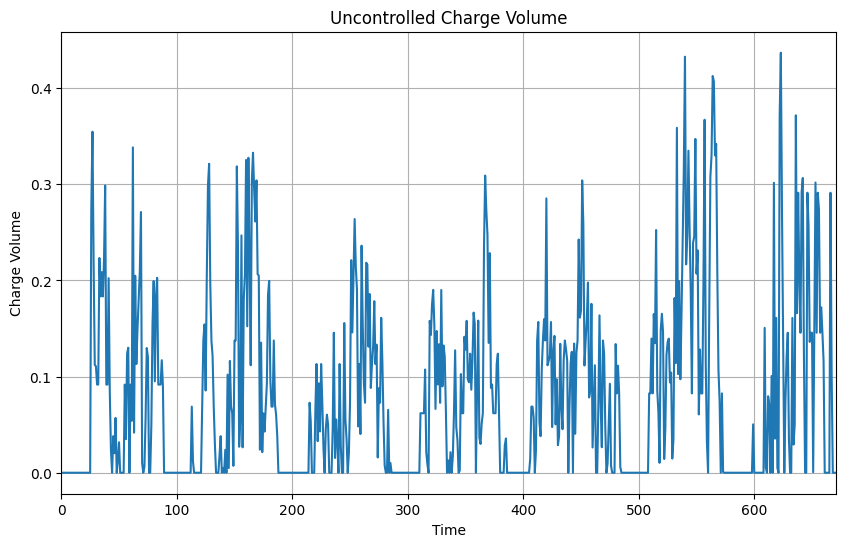

In [50]:
# Estimate charging flexibility based on driving profiles and charge connection
flex = FlexEstimator(configs=configs, activities=grid.activities)
flex.estimate_technical_flexibility_through_iteration()

diary = DiaryBuilder(configs=configs, activities=flex.activities)
diary.create_diaries()


profiles = ProfileAggregator(configs=configs, activities=diary.activities, profiles=diary)
profiles.aggregate_profiles()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(profiles.uncontrolled_charging_weekly.index, profiles.uncontrolled_charging_weekly.iloc[:])  
plt.xlim(profiles.uncontrolled_charging_weekly.index[0], profiles.uncontrolled_charging_weekly.index[-1])
plt.title('Uncontrolled Charge Volume')
plt.xlabel('Time')
plt.ylabel('Charge Volume')
plt.grid(True)

plt.show()


We can now change the grid availability from home to the workplace only and see how this affects the available charging flexibility.

In [51]:
configs['user_config']['gridmodellers']['charging_infrastructure_mappings']['HOME'] = False
configs['user_config']['gridmodellers']['charging_infrastructure_mappings']['WORK'] = True
configs['user_config']['gridmodellers']['charging_infrastructure_mappings']

{'DRIVING': False,
 'HOME': False,
 'WORK': True,
 'SCHOOL': False,
 'SHOPPING': True,
 'LEISURE': True,
 'OTHER': False,
 'NA': False,
 'PEOPLE_MOBILITY': False,
 'TRANSPORT': False,
 'SERVICES': False}

In [52]:
grid = GridModeller(configs=configs, activities=data)
grid.assign_grid()



Starting with charge connection replacement of location purposes.
Grid connection assignment complete.


Starting maximum battery level calculation.
Calculating maximum battery level for first activities.
Calculating maximum battery level for act 1.
Calculating maximum battery level for act 2.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:244: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_park_activities.loc[:, "max_battery_level_end_unlimited"] = (
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:247: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_park_activities.loc[:, "max_battery_level_end"] = first_park_activities.loc[:,
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:253: FutureWarning: In a future version, `df.iloc[:,

Calculating maximum battery level for act 3.
Calculating maximum battery level for act 4.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:346: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_battery_level_end_unlimited"] = (
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:350: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_battery_level_end"] = indeces_trip_activities.loc[
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning

Calculating maximum battery level for act 5.
Calculating maximum battery level for act 6.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:443: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_park_activities.loc[multi_index_park, "max_battery_level_start"] = indeces_previous_trip_activities.loc[
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:450: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_park_activities.loc[multi_index_park, "max_battery_level_end"] = indeces_park_activities[
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimato

Calculating maximum battery level for act 7.
Calculating maximum battery level for act 8.
Calculating maximum battery level for act 9.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:443: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_park_activities.loc[multi_index_park, "max_battery_level_start"] = indeces_previous_trip_activities.loc[
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:450: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_park_activities.loc[multi_index_park, "max_battery_level_end"] = indeces_park_activities[
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimato

Calculating maximum battery level for act 10.
Calculating maximum battery level for act 11.
Calculating maximum battery level for act 12.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:350: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_battery_level_end"] = indeces_trip_activities.loc[
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:443: FutureWarning: In 

Starting minimum battery level calculation.
Calculate minimum battery level for last activities.
Calculate minimum battery level for act 12.
Calculate minimum battery level for act 11.
Calculate minimum battery level for act 10.
Calculate minimum battery level for act 9.
Calculate minimum battery level for act 8.
Calculate minimum battery level for act 7.
Calculate minimum battery level for act 6.
Calculate minimum battery level for act 5.
Calculate minimum battery level for act 4.
Calculate minimum battery level for act 3.
Calculate minimum battery level for act 2.
Calculate minimum battery level for act 1.
Calculate minimum battery level for act 0.
Finished iteration 1 / 10. Delta max battery level is 3166, delta min battery level is 840 and threshold epsilon is 1.
Starting maximum battery level calculation.
Calculating maximum battery level for first activities.
Calculating maximum battery level for act 1.
Calculating maximum battery level for act 2.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:253: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_park_activities.loc[:, "max_overshoot"] = (
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:274: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_trip_activities.loc[:, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the v

Calculating maximum battery level for act 3.
Calculating maximum battery level for act 4.
Calculating maximum battery level for act 5.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 6.
Calculating maximum battery level for act 7.
Calculating maximum battery level for act 8.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 9.
Calculating maximum battery level for act 10.
Calculating maximum battery level for act 11.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 12.
Finished iteration 1 / 10. Delta max battery level is 539, delta min battery level is 840 and threshold epsilon is 1.
Starting maximum battery level calculation.
Calculating maximum battery level for first activities.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:253: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_park_activities.loc[:, "max_overshoot"] = (
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:274: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will att

Calculating maximum battery level for act 1.
Calculating maximum battery level for act 2.
Calculating maximum battery level for act 3.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 4.
Calculating maximum battery level for act 5.
Calculating maximum battery level for act 6.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 7.
Calculating maximum battery level for act 8.
Calculating maximum battery level for act 9.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 10.
Calculating maximum battery level for act 11.
Calculating maximum battery level for act 12.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(


Finished iteration 2 / 10. Delta max battery level is 278, delta min battery level is 840 and threshold epsilon is 1.
Starting maximum battery level calculation.
Calculating maximum battery level for first activities.
Calculating maximum battery level for act 1.
Calculating maximum battery level for act 2.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:253: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_park_activities.loc[:, "max_overshoot"] = (
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:274: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_trip_activities.loc[:, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the v

Calculating maximum battery level for act 3.
Calculating maximum battery level for act 4.
Calculating maximum battery level for act 5.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 6.
Calculating maximum battery level for act 7.
Calculating maximum battery level for act 8.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 9.
Calculating maximum battery level for act 10.
Calculating maximum battery level for act 11.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 12.
Finished iteration 3 / 10. Delta max battery level is 181, delta min battery level is 840 and threshold epsilon is 1.
Starting maximum battery level calculation.
Calculating maximum battery level for first activities.
Calculating maximum battery level for act 1.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:253: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_park_activities.loc[:, "max_overshoot"] = (
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:274: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will att

Calculating maximum battery level for act 2.
Calculating maximum battery level for act 3.
Calculating maximum battery level for act 4.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 5.
Calculating maximum battery level for act 6.
Calculating maximum battery level for act 7.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 8.
Calculating maximum battery level for act 9.
Calculating maximum battery level for act 10.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 11.
Calculating maximum battery level for act 12.
Finished iteration 4 / 10. Delta max battery level is 109, delta min battery level is 840 and threshold epsilon is 1.
Starting maximum battery level calculation.
Calculating maximum battery level for first activities.
Calculating maximum battery level for act 1.
Calculating maximum battery level for act 2.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:253: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_park_activities.loc[:, "max_overshoot"] = (
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:274: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_trip_activities.loc[:, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the v

Calculating maximum battery level for act 3.
Calculating maximum battery level for act 4.
Calculating maximum battery level for act 5.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 6.
Calculating maximum battery level for act 7.
Calculating maximum battery level for act 8.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 9.
Calculating maximum battery level for act 10.
Calculating maximum battery level for act 11.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 12.
Finished iteration 5 / 10. Delta max battery level is 68, delta min battery level is 840 and threshold epsilon is 1.
Starting maximum battery level calculation.
Calculating maximum battery level for first activities.
Calculating maximum battery level for act 1.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:253: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_park_activities.loc[:, "max_overshoot"] = (
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:274: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will att

Calculating maximum battery level for act 2.
Calculating maximum battery level for act 3.
Calculating maximum battery level for act 4.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 5.
Calculating maximum battery level for act 6.
Calculating maximum battery level for act 7.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 8.
Calculating maximum battery level for act 9.
Calculating maximum battery level for act 10.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 11.
Calculating maximum battery level for act 12.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(


Finished iteration 6 / 10. Delta max battery level is 57, delta min battery level is 840 and threshold epsilon is 1.
Starting maximum battery level calculation.
Calculating maximum battery level for first activities.
Calculating maximum battery level for act 1.
Calculating maximum battery level for act 2.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:253: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_park_activities.loc[:, "max_overshoot"] = (
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:274: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_trip_activities.loc[:, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the v

Calculating maximum battery level for act 3.
Calculating maximum battery level for act 4.
Calculating maximum battery level for act 5.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 6.
Calculating maximum battery level for act 7.
Calculating maximum battery level for act 8.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 9.
Calculating maximum battery level for act 10.
Calculating maximum battery level for act 11.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 12.
Finished iteration 7 / 10. Delta max battery level is 48, delta min battery level is 840 and threshold epsilon is 1.
Starting maximum battery level calculation.
Calculating maximum battery level for first activities.
Calculating maximum battery level for act 1.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:253: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_park_activities.loc[:, "max_overshoot"] = (
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:274: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will att

Calculating maximum battery level for act 2.
Calculating maximum battery level for act 3.
Calculating maximum battery level for act 4.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 5.
Calculating maximum battery level for act 6.
Calculating maximum battery level for act 7.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 8.
Calculating maximum battery level for act 9.
Calculating maximum battery level for act 10.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 11.
Calculating maximum battery level for act 12.
Finished iteration 8 / 10. Delta max battery level is 43, delta min battery level is 840 and threshold epsilon is 1.
Starting maximum battery level calculation.
Calculating maximum battery level for first activities.
Calculating maximum battery level for act 1.
Calculating maximum battery level for act 2.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:253: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_park_activities.loc[:, "max_overshoot"] = (
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:274: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_trip_activities.loc[:, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the v

Calculating maximum battery level for act 3.
Calculating maximum battery level for act 4.
Calculating maximum battery level for act 5.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 6.
Calculating maximum battery level for act 7.
Calculating maximum battery level for act 8.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 9.
Calculating maximum battery level for act 10.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 11.
Calculating maximum battery level for act 12.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:253: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  first_park_activities.loc[:, "max_overshoot"] = (
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:274: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will att

Finished iteration 9 / 10. Delta max battery level is 34, delta min battery level is 840 and threshold epsilon is 1.
Starting maximum battery level calculation.
Calculating maximum battery level for first activities.
Calculating maximum battery level for act 1.
Calculating maximum battery level for act 2.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(


Calculating maximum battery level for act 3.
Calculating maximum battery level for act 4.
Calculating maximum battery level for act 5.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 6.
Calculating maximum battery level for act 7.
Calculating maximum battery level for act 8.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 9.
Calculating maximum battery level for act 10.
Calculating maximum battery level for act 11.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(
C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.

Calculating maximum battery level for act 12.


C:\Users\jagm_li\Documents\vencopy_internal\vencopy\vencopy\core\flexestimators.py:361: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  indeces_trip_activities.loc[multi_index_trip, "max_residual_need"] = res.where(


Finished iteration 10 / 10. Delta max battery level is 27, delta min battery level is 840 and threshold epsilon is 1.
Technical flexibility estimation ended.
146 activities dropped from 1455 total activities because activity length equals zero.
Starting to discretise drain.
Discretisation finished for drain.
Needed time to discretise drain: 0.5139966011047363.
Starting to discretise available_power.
Discretisation finished for available_power.
Needed time to discretise available_power: 0.5029962062835693.
Starting to discretise uncontrolled_charging.
Discretisation finished for uncontrolled_charging.
Needed time to discretise uncontrolled_charging: 0.5520210266113281.
Starting to discretise max_battery_level_start.
Discretisation finished for max_battery_level_start.
Needed time to discretise max_battery_level_start: 0.5469779968261719.
Starting to discretise min_battery_level_end.
Discretisation finished for min_battery_level_end.
Needed time to discretise min_battery_level_end: 0.551

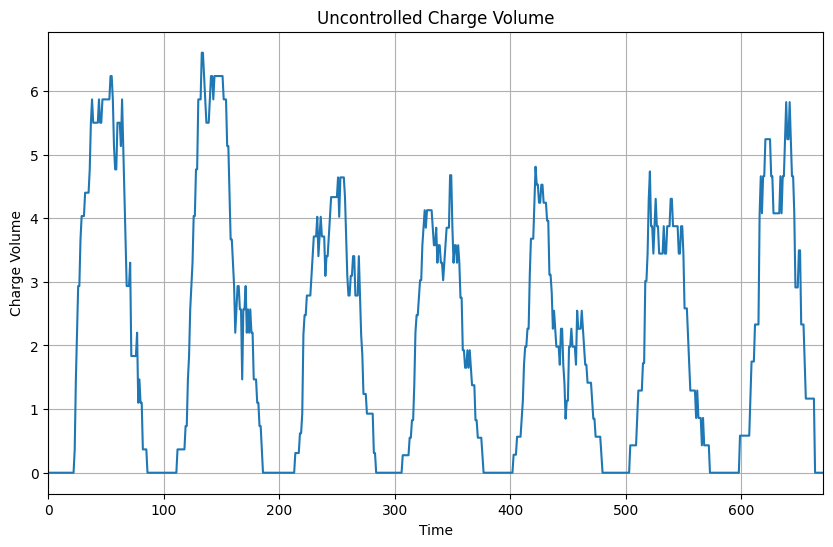

In [53]:
# Estimate charging flexibility based on driving profiles and charge connection
flex = FlexEstimator(configs=configs, activities=grid.activities)
flex.estimate_technical_flexibility_through_iteration()

diary = DiaryBuilder(configs=configs, activities=flex.activities)
diary.create_diaries()


profiles = ProfileAggregator(configs=configs, activities=diary.activities, profiles=diary)
profiles.aggregate_profiles()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(profiles.charging_power_weekly.index, profiles.charging_power_weekly.iloc[:])  
plt.xlim(profiles.charging_power_weekly.index[0], profiles.charging_power_weekly.index[-1])
plt.title('Uncontrolled Charge Volume')
plt.xlabel('Time')
plt.ylabel('Charge Volume')
plt.grid(True)

plt.show()

From the plots we can see how different the charging power looks, when the option of home charging is cancelled.  

## Next Steps

In the next tutorial, you will learn more in detail the internal workings of the FlexEstimator class and how to customise some settings.